# Customer Lifetime Value (CLTV) prediction

__Customer Lifetime Value (CLTV)__ is the total revenue a customer will generate for a business over the duration of their relationship.

By analyzing CLTV, businesses can:

* __Understand the profitability of a customer__: CLTV allows businesses to identify their most profitable customers and develop targeted marketing strategies to retain them. By doing so, businesses can optimize their marketing budget and improve their ROI.

* __Develop a customer-centric strategy__: By analyzing CLTV, businesses can understand customer behavior, preferences, and purchase history. This information can be used to develop a customer-centric strategy that meets the needs and expectations of the customers.

* __Predict future revenue__: CLTV allows businesses to forecast future revenue by identifying the revenue potential of each customer. This information can be used to develop a revenue forecasting model that helps businesses to plan their budget and resources.

* __Improve customer loyalty__: CLTV helps businesses to identify their most loyal customers and develop targeted strategies to retain them. By doing so, businesses can improve customer loyalty, increase customer lifetime value, and reduce customer churn.

Overall, CLTV is a powerful metric that can help businesses to optimize their marketing strategy, improve customer loyalty, and increase revenue.

We have the transactional data of a retail business. Each row represents a single transaction and contains the following information:

* CustomerID: unique identifier for the customer who made the purchase.
* InvoiceNo: unique identifier for the transaction.
* InvoiceDate: the date the transaction occurred in the format DD/MM/YYYY.
* StockCode: unique identifier for the product purchased.
* Description: description of the product purchased.
* Quantity: the number of units of the product purchased in the transaction.
* UnitPrice: the price of a single unit of the product.

## Data preprocessing

In [1]:
import pandas as pd

df = pd.read_csv("https://github.com/Polanitz/CLV-E2E-Research-to-Production/raw/main/company.zip", encoding="cp1252")
df.head()

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice
0,17850.0,536365,25/09/2020,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,8.415
1,17850.0,536365,25/09/2020,71053,WHITE METAL LANTERN,6,11.187
2,17850.0,536365,25/09/2020,84406B,CREAM CUPID HEARTS COAT HANGER,8,9.075
3,17850.0,536365,25/09/2020,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11.187
4,17850.0,536365,25/09/2020,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11.187


Let us check basic statistics of the data

In [2]:
df.describe()

,CustomerID,Quantity,UnitPrice
count,361878.000000,495478.000000,495478.000000
mean,15547.871368,8.605486,14.956993
std,1594.402590,227.588756,327.740946
min,12346.000000,-80995.000000,-36504.798000
25%,14194.000000,1.000000,4.125000
50%,15514.000000,3.000000,6.930000
75%,16931.000000,10.000000,13.629000
max,18287.000000,80995.000000,128601.000000


In general, it's not common for quantities or prices to be negative in transactional data. However, negative quantities or prices can occur in certain situations, such as:

* __Returns__: If a customer returns an item, the transaction may be recorded as a negative quantity with a negative price. This is because the customer is returning the item and receiving a refund for the amount they paid.

* __Discounts__: If a customer receives a discount on an item, the transaction may be recorded as a negative price. This is because the customer is paying less than the original price of the item.

* __Data entry errors__: Negative quantities or prices can also occur due to data entry errors, such as accidentally typing a minus sign or entering the wrong value.

It's important to identify and handle negative quantities or prices appropriately in your analysis. Depending on the specific situation, you may want to remove these transactions from your dataset, treat them as separate categories, or adjust them to reflect the correct values.

We are currently focusing on the machine learning aspect of the solution, so we will skip such observations for now. However, in the real world, such data issues can result in an entirely inappropriate model, which could negatively impact the business. To address this, it may be necessary to identify potential problems in the data gathering and preparation processes and modify the pipeline accordingly.

In [3]:
# Remove any rows with negative quantities or prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


Secondly, we have observed that the number of unique CustomerIDs is less than the number of observations in other columns. Since our goal is to predict the lifetime value for each customer, data with missing customer indices is irrelevant. In general, we should investigate potential issues in the data gathering pipeline. However, for simplicity, we will drop these observations for now.

In [4]:
# Remove any rows with missing CustomerID
df = df[~df.CustomerID.isna()]

# Check whether the descriptions that were missing before have been removed from the dataset

df.isna().sum()

CustomerID     0
InvoiceNo      0
InvoiceDate    0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
dtype: int64

The 75th percentile and maximum values for the Quantity and UnitPrice columns differ significantly, which could be an indication of outliers in the data. As mentioned earlier, it's important to investigate the cause of such data points before removing them. However, for now, let's proceed with removing them.

In [5]:
Q = df.quantile(0.99)
# Filter out outliers in the Quantity column
df = df[~(df['Quantity'] > Q["Quantity"])]

# Filter out outliers in the UnitPrice column
df = df[~(df['UnitPrice'] > Q["UnitPrice"])]

<ipython-input-5-e5153ed1f462>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q = df.quantile(0.99)


Next, we add a new column for the total cost of each purchase, and group the data by customer to calculate their total spending, total purchases, and latest purchase date. Finally, we rename the columns to make them more descriptive.

In [6]:
from dateutil.relativedelta import relativedelta

# Convert the InvoiceDate column to a datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y')

# Convert the CustomerID column to an integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Add a column for the total cost of each purchase
df['TotalCost'] = df['Quantity'] * df['UnitPrice']

df["FirstTime"] = df.CustomerID.map(df.groupby("CustomerID").InvoiceDate.min().to_dict())

# Calculate the difference in months between the InvoiceDate column and the latest purchase date
def calculate_relative_difference(x):
    diff = relativedelta(x['InvoiceDate'], x["FirstTime"])
    return diff.years * 12 + diff.months

df['MonthsSinceFirstPurchase'] = df.apply(calculate_relative_difference, axis=1)

# Group the data by customer and calculate their total spending, total purchases, and latest purchase date
df["InvoiceDate2"] = df["InvoiceDate"]
customer_data = df.groupby(['CustomerID', 'MonthsSinceFirstPurchase']).agg({
    'TotalCost': 'sum',
    'InvoiceNo': 'nunique',
    'InvoiceDate': 'min',
    'InvoiceDate2': 'max'
}).reset_index()

# Rename the columns
customer_data.columns = ['CustomerID', "MonthsSinceFirstPurchase", 'TotalSpending', 'TotalPurchases', 'FirstPurchaseDate', 'LatestPurchaseDate']

customer_data.head()

,CustomerID,MonthsSinceFirstPurchase,TotalSpending,TotalPurchases,FirstPurchaseDate,LatestPurchaseDate
0,12747,0,2330.691,2,2020-09-30,2020-10-07
1,12747,1,1000.032,1,2020-11-15,2020-11-15
2,12747,2,1025.574,1,2020-12-25,2020-12-25
3,12747,5,2443.353,2,2021-02-28,2021-03-19
4,12747,6,1241.790,1,2021-04-22,2021-04-22


Our dataset only contains observations from one year, so we cannot predict the lifetime value accurately. However, we can choose a specific period to make our prediction. For instance, we could predict the lifetime value for six months based on the first three months of data. To ensure the dataset's validity, we should only consider users who made their first purchase at least six months before the last observation.

In [7]:
customer_data = customer_data[((customer_data.LatestPurchaseDate.max() - customer_data.FirstPurchaseDate).dt.days >= 183)]
customer_data.head()

,CustomerID,MonthsSinceFirstPurchase,TotalSpending,TotalPurchases,FirstPurchaseDate,LatestPurchaseDate
0,12747,0,2330.691,2,2020-09-30,2020-10-07
1,12747,1,1000.032,1,2020-11-15,2020-11-15
2,12747,2,1025.574,1,2020-12-25,2020-12-25
3,12747,5,2443.353,2,2021-02-28,2021-03-19
9,12748,0,13844.259,35,2020-09-25,2020-10-18


We will take the first three months as features

In [8]:
customer_data = customer_data[['CustomerID', "MonthsSinceFirstPurchase", 'TotalSpending', 'TotalPurchases']]
X = pd.pivot(customer_data[customer_data["MonthsSinceFirstPurchase"] <= 2], index="CustomerID", columns=["MonthsSinceFirstPurchase"]).fillna(0)

And will predict the values for the first six-month period

In [9]:
cltv = customer_data[customer_data["MonthsSinceFirstPurchase"] <= 6].groupby("CustomerID").TotalSpending.sum().rename("cltv")
prepared_data = X.join(cltv)

# Split the data into features (X) and target variable (y)
X = prepared_data.drop("cltv", axis=1).values
y = prepared_data["cltv"].values

<ipython-input-9-662c3cd806b6>:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  prepared_data = X.join(cltv)


## Train-test split

A hold-out set, also known as a validation set, is a subset of the data used for evaluating the performance of a machine learning model after it has been trained on the training set. It is important to use a hold-out set because it allows us to test the model on unseen data and get an estimate of its performance on new data.

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Cross-validation

Cross-validation is a technique to evaluate a model's performance and generalization ability by splitting data into non-overlapping folds. In k-fold cross-validation, the model is trained on k-1 folds and tested on the remaining fold, repeated k times. It's more accurate than using a single hold-out set and helps detect overfitting, but can be computationally expensive and assumes IID data.

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*AAwIlHM8TpAVe4l2FihNUQ.png)

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error


def run_kfold_cv(X, y, model):
    # Initialize the KFold class
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize a list to store the scores
    mse_scores = []
    mae_scores = []
    mape_scores = []

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        # Use the model to make predictions on the testing set
        y_pred = model.predict(X_test)

        # Calculate the mean squared error (MSE) and store it in the list
        mse_scores.append(mean_squared_error(y_test, y_pred))
        # Calculate the mean absolute error (MAE) and store it in the list
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        # Calculate the mean absolute percentage error (MAPE) and store it in the list
        mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))

    # Calculate the average score
    return  sum(mse_scores) / len(mse_scores), sum(mae_scores) / len(mae_scores), sum(mape_scores) / len(mape_scores)

Let us train different models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

for model_name, model in [
    ("Linear regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
]:
    scores = run_kfold_cv(X_train, y_train, model)
    print("{}: MSE {:.2f}, MAE {:.2f}, MAPE {:.2f}".format(model_name, *scores))

Linear regression: MSE 5241974.83, MAE 976.22, MAPE 0.48
Random Forest: MSE 7992360.02, MAE 958.91, MAPE 0.33
Gradient Boosting: MSE 7670331.82, MAE 949.91, MAPE 0.37


It is important to prepare both features and targets in machine learning tasks. In some cases, it may be helpful to transform the target variable, especially if its distribution is skewed or does not meet the assumptions of the model being used.

In the given example, the distribution of the target variable is said to be log-normal. This means that the logarithm of the target variable follows a normal distribution. In such cases, it may be beneficial to transform the target variable by taking its logarithm before using it in a predictive model. This can make it easier for the model to capture patterns in the data and make more accurate predictions.

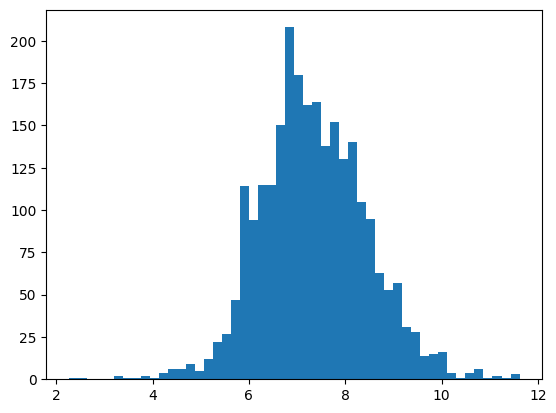

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
plt.hist(np.log(y), bins=50);

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error


def run_kfold_cv_log(X, y, model):
    # Initialize the KFold class
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize a list to store the scores
    mse_scores = []
    mae_scores = []
    mape_scores = []

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, np.log(y_train))

        # Use the model to make predictions on the testing set
        y_pred = np.exp(model.predict(X_test))

        # Calculate the mean squared error (MSE) and store it in the list
        mse_scores.append(mean_squared_error(y_test, y_pred))
        # Calculate the mean absolute error (MAE) and store it in the list
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        # Calculate the mean absolute percentage error (MAPE) and store it in the list
        mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))

    # Calculate the average score
    return  sum(mse_scores) / len(mse_scores), sum(mae_scores) / len(mae_scores), sum(mape_scores) / len(mape_scores)

for model_name, model in [
    ("Linear regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
]:
    scores = run_kfold_cv_log(X_train, y_train, model)
    print("{}: MSE {:.2f}, MAE {:.2f}, MAPE {:.2f}".format(model_name, *scores))

Linear regression: MSE 112995700181143312.00, MAE 7520965.89, MAPE 114.78
Random Forest: MSE 9569979.53, MAE 957.74, MAPE 0.26
Gradient Boosting: MSE 7205109.13, MAE 870.89, MAPE 0.27


However, some models is sensitive to the scale of features and may require scaling of features or similar tranformations.

In [ ]:
X_transformed = np.concatenate([np.log1p(X_train[:, :3]), X_train[:, 3:]], axis=1)

for model_name, model in [
    ("Linear regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
]:
    scores = run_kfold_cv_log(X_transformed, y_train, model)
    print("{}: MSE {:.2f}, MAE {:.2f}, MAPE {:.2f}".format(model_name, *scores))

Linear regression: MSE 15523219.07, MAE 1086.40, MAPE 0.27
Random Forest: MSE 9887396.69, MAE 959.12, MAPE 0.24
Gradient Boosting: MSE 7251773.27, MAE 875.87, MAPE 0.22


## Hyper-parameter tuning

Performing hyperparameter optimization with cross-validation is a common technique to find the best hyperparameters for a given model. One popular method for doing so is grid search, where you specify a range of values for each hyperparameter, and the algorithm exhaustively searches through all possible combinations of hyperparameters to find the best ones.

__!!! this cell can take a while !!!__

In [ ]:
from sklearn.model_selection import GridSearchCV

# Initialize a random forest regressor object
gbm = GradientBoostingRegressor()

# Define a dictionary of hyperparameters and their ranges
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize a grid search cross-validation object
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(X_transformed, np.log(y_train))

# Print the best hyperparameters and their corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)


Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 0.13101660579673266


In [ ]:
X_transformed_test = np.concatenate([np.log1p(X_test[:, :3]), X_test[:, 3:]], axis=1)
y_test_pred = np.exp(grid_search.predict(X_transformed_test))


print("GradientBoosting: MSE {:.2f}, MAE {:.2f}, MAPE {:.2f}".format(
    mean_squared_error(y_test, y_test_pred),
    mean_absolute_error(y_test, y_test_pred),
    mean_absolute_percentage_error(y_test, y_test_pred)
))


GradientBoosting: MSE 6370973.64, MAE 855.32, MAPE 0.22


During cross-validation, multiple models are trained using different subsets of the data. So, you receive several models prediction of which can be average and possibly improves the overall results.

In [ ]:
def run_kfold_averaging(X, y, X_test, y_test, model):
    # Initialize the KFold class
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize a list to store the scores
    mse_scores = []
    mae_scores = []
    mape_scores = []
    preds = []
    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train = X[train_index]
        y_train = y[train_index]

        model = GradientBoostingRegressor(**grid_search.best_params_)
        model.fit(X_train, np.log(y_train))

        # Use the model to make predictions on the testing set
        y_pred = np.exp(model.predict(X_test))
        preds.append(y_pred)

        # Calculate the mean squared error (MSE) and store it in the list
        mse_scores.append(mean_squared_error(y_test, y_pred))
        # Calculate the mean absolute error (MAE) and store it in the list
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        # Calculate the mean absolute percentage error (MAPE) and store it in the list
        mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
    preds = np.array(preds).mean(0)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mse, mae, mape, np.mean(mse_scores), np.mean(mae_scores), np.mean(mape_scores)

In [ ]:
scores = run_kfold_averaging(X, y, X_test, y_test, GradientBoostingRegressor(**grid_search.best_params_))

print("Average of individual models scores: MSE {:.2f}, MAE {:.2f}, MAPE {:.2f}".format(*scores[3:]))
print("Average of different models predictions: MSE {:.2f}, MAE {:.2f}, MAPE {:.2f}".format(*scores[:3]))

Average of individual models scores: MSE 2729930.27, MAE 596.70, MAPE 0.19
Average of different models predictions: MSE 1633045.23, MAE 539.18, MAPE 0.18
